<a href="https://colab.research.google.com/github/kimkyeonghyun/AI_math_tutorial/blob/main/AiWeek3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Activation Functions

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial3/Activation_Functions.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial3/Activation_Functions.ipynb)   
**Pre-trained models:**
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial3)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1sFpZUpDJVjiYEvIqISqfkFizfsTnPf4s?usp=sharing)   
**Recordings:**
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/3C_m71NDkPs)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/GjCfAeHGq9U)   
**JAX+Flax version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial3/Activation_Functions.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** Interested in JAX? Check out our [JAX+Flax version](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial3/Activation_Functions.html) of this tutorial!
</div>

본 튜토리얼에서는 자주 쓰이는 활성화 함수에 대해 자세히 살펴보고, 신경망에서 최적화 특성에 미치는 영향을 알아 볼 것이다. 활성화 함수는 신경망에 비선형성을 추가하므로 딥러닝 모델의 중요한 부분이다. 다양한 활성화 함수가 존재하며, 그중 일부는 다른 함수들보다 더 유익하다.

이 튜토리얼의 목표는 좋은 활성화 함수를 선택하는 것이 얼마나 중요한지, 어떻게 선택하는지를 알아보고, 적절한 활성화 함수를 선택하지 않았을 때 발생할 수 있는 문제를 확인하는 것이다.

시작하기 전에, 표준 라이브러리를 가져오고 기본 함수를 설정한다.

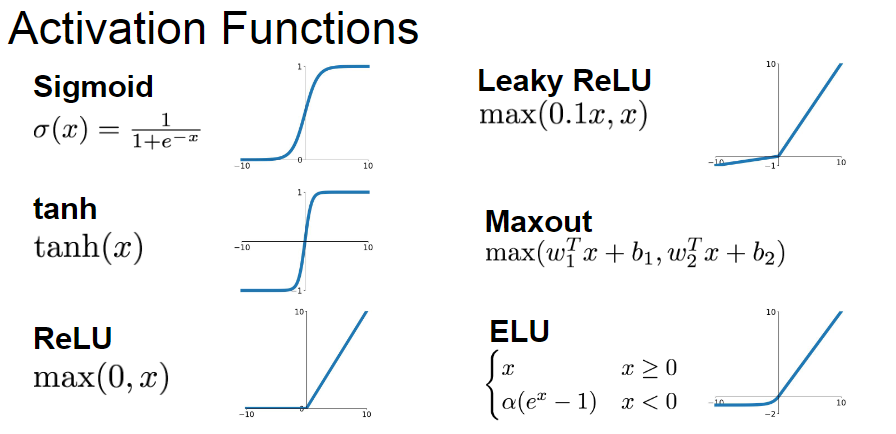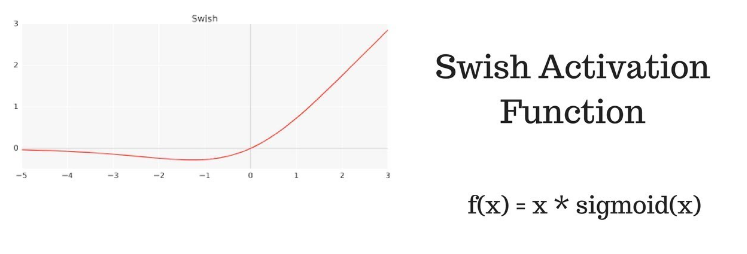

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

이 튜토리얼에서 상호작용할 수 있는 모든 라이브러리(여기서는 numpy와 torch)에 시드를 설정하는 함수를 정의할 것이다. 이는 훈련을 재현 가능하게 만들어 준다. 그러나 CPU와 달리, 서로 다른 GPU 아키텍처에서 동일한 시드를 사용할 경우 다른 결과를 얻을 수 있다는 점에 유의해야한다. 여기서 사용된 모든 모델은 NVIDIA GTX1080Ti에서 훈련되었다.

추가적으로, 다음 셀에서는 두 경로 'DATASET_PATH'와 'CHECKPOINT_PATH'를 지정한다. DATASET_PATH는 노트북에서 사용할 데이터셋을 다운로드할 디렉터리이다. PyTorch의 모든 데이터셋을 하나의 디렉터리에 저장하여 중복 다운로드를 방지하는 것이 좋다. CHECKPOINT_PATH는 훈련된 모델 가중치와 추가 파일을 저장할 디렉터리이다. 필요한 파일들은 자동으로 다운로드된다. Google Colab을 사용하는 경우, 현재 디렉터리에서 시작하도록 경로를 변경하는 것이 좋다. 즉, 데이터셋(dataset)과 체크포인트 경로(checkpoint path)에서 '../'를 제거해야한다.

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/saved_models/tutorial3"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

다음 셀은 이 노트북에서 사용할 모든 사전 훈련된 모델을 다운로드한다. 파일들은 노트북 저장소의 크기를 줄이기 위해 별도의 저장소[repository](https://github.com/phlippe/saved_models)에 저장되어 있다. 특히 ReadTheDocs에서 문서를 작성할 때 유용하다. 만약 아래 다운로드가 실패하면, Google 드라이브 폴더[Google Drive folder](https://drive.google.com/drive/folders/1sFpZUpDJVjiYEvIqISqfkFizfsTnPf4s?usp=sharing)에서 모델을 다운로드할 수 있다.


In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Common activation functions

첫 번째 단계로, 몇 가지 일반적인 활성화 함수를 직접 구현해 볼 것이다. 대부분은 torch.nn 패키지에서 찾을 수 있다(개요는 [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)를 참조).
그러나 더 나은 이해와 통찰을 위해 여기서는 직접 함수를 작성해 볼 것이다.

다양한 활성화 함수를 쉽게 비교하기 위해, 앞으로 작성할 모든 모듈이 상속받을 '기본 클래스'를 정의하는 것부터 시작할 것이다.

In [ ]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

모든 활성화 함수는 네트워크에 잘 통합될 수 있도록 `nn.Module`이 된다.

 `config` 사전을 사용하여 일부 활성화 함수의 조정 가능한 매개변수를 저장할 것이다.

다음으로, 다양한 작업에 일반적으로 사용되는 가장 오래된 활성화 함수인 sigmoid와 tanh를 구현해 볼 것이다.

sigmoid와 tanh 활성화 함수는 PyTorch 함수(`torch.sigmoid`, `torch.tanh`) 또는 모듈(`nn.Sigmoid`, `nn.Tanh`)로도 찾을 수 있다.

여기서 이들을 직접 구현해 볼 것이다.


In [ ]:
##############################

class Sigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

##############################

class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

##############################

깊은 네트워크의 훈련을 가능하게 한 또 다른 인기 있는 활성화 함수는 Rectified Linear Unit (ReLU)이다.
두 개의 선형함수의 결합이라는 단순함에도 불구하고, ReLU는 sigmoid와 tanh에 비해 하나의 주요한 장점을 가지고 있다. 이는 넓은 범위의 값들에 대해 강하고 안정적인 기울기를 제공한다는 점이다.

이 아이디어를 바탕으로 많은 ReLU 변형들이 제안되었으며,그 중 세 가지인 LeakyReLU, ELU, Swish를 구현할 것이다.
LeakyReLU는 입력의 음수 부분에서 기울기를 흐를 수 있도록 0의 기울기 대신 작은 값의 기울기를 사용한다.

유사하게, ELU는 음수 부분을 지수 감쇠로 대체한다.

가장 최근에 제안된 활성화 함수는 Swish이다. Swish는 최적의 활성화 함수를 찾기 위한 대규모 실험의 결과이다.
다른 활성화 함수와 비교하여, Swish는 매끄럽고 비단조적이다. 또한 기울기에서 부호 변화가 포함된다.
이는 특히 깊은 네트워크에서 표준 ReLU 활성화처럼 비활성화 뉴런을 방지하는 것으로 나타났다.
Swish의 장점에 대한 보다 자세한 논의는 [이 논문](https://arxiv.org/abs/1710.05941) [1].에서 찾을 수 있다.


아래에서 네 가지 활성화 함수를 구현해 볼 것이다.


In [ ]:
##############################

class ReLU(ActivationFunction):

    def forward(self, x):
        return x * (x > 0).float()

##############################

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

##############################

class ELU(ActivationFunction):

    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

##############################

class Swish(ActivationFunction):

    def forward(self, x):
        return x * torch.sigmoid(x)

##############################

나중에 사용하기 위해, 모든 활성화 함수를 이름과 클래스 객체를 매핑하는 사전에 요약해둔다.

 만약 새로운 활성화 함수를 직접 구현하게 되면, 여기에 추가하여 향후 비교에 포함시킬 수 있다.

In [ ]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

### Visualizing activation functions

각 활성화 함수가 실제로 어떤 일을 하는지 이해하기 위해, 이를 시각화해 볼 것이다.

실제 활성화 값 옆에 함수의 기울기도 시각화할 것인데, 이는 신경망을 최적화하는 데 매우 중요하다.

PyTorch에서는 `backward` 함수를 호출하여 기울기를 간단히 계산할 수 있다.


In [ ]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

이제 모든 활성화 함수와 그 기울기를 시각화할 수 있다.

In [ ]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

## Analysing the effect of activation functions

활성화 함수를 구현하고 시각화한 후, 그 효과에 대한 인사이트를 얻고자 한다.

이를 위해 [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist)에서 훈련된 간단한 신경망을 사용하여 모델의 성능과 기울기 흐름을 포함한 다양한 측면을 알아볼 것이다.

### Setup

먼저, 신경망을 설정한다. 선택한 네트워크는 이미지를 1D 텐서로 보고, 이를 일련의 선형 층과 지정된 활성화 함수를 통해 전달한다.

다른 네트워크 아키텍처로 실험해보아도 좋다.

In [ ]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out


모델을 로드하고 저장하기 위한 함수를 추가한다.

하이퍼파라미터는 구성 파일(간단한 json 파일)에 저장된다.

In [ ]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.

    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

우리가 훈련하고자 하는 데이터셋, [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist)을 설정한다. FashionMNIST는 MNIST의 더 복잡한 버전으로, 숫자 대신 옷의 흑백 이미지를 포함한다. 10개의 클래스에는 바지, 코트, 신발, 가방 등이 포함된다. 이 데이터셋을 로드하기 위해 또 다른 PyTorch 패키지인 `torchvision`([문서 참조](https://pytorch.org/docs/stable/torchvision/index.html))을 사용한다. `torchvision` 패키지는 인기 있는 데이터셋, 모델 아키텍처, 공통 이미지 변환 등을 포함하여 컴퓨터 비전을 위한 도구를 제공한다.많은 노트북에서 데이터셋 처리를 간소화하기 위해 이 패키지를 사용할 것이다.

아래에서 데이터셋을 로드하고, 데이터를 이해하기 위해 몇 가지 이미지를 시각화해 보자.

In [ ]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [ ]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Visualizing the gradient flow after initialization

앞서 언급했듯이, 활성화 함수의 중요한 측면 중 하나는 네트워크를 통해 기울기를 어떻게 전파하는지이다.

50개 이상의 층을 가진 매우 깊은 신경망을 상상해 보자.

가장 첫 번째 층인 입력층의 기울기는 50번 이상의 활성화 함수를 통과했지만 여전히 적절한 크기를 유지하길 원한다.

활성화 함수를 통한 기울기가 1보다 상당히 작으면, 기울기가 입력층에 도달하기 전에 소실될 것이다. 활성화 함수를 통한 기울기가 1보다 크면, 기울기가 기하급수적으로 증가하여 폭발할 수 있다.

각 활성화 함수가 기울기에 어떻게 영향을 미치는지 이해하기 위해, 새로 초기화된 네트워크를 살펴보고 256개의 이미지 배치에 대해 각 매개변수의 기울기를 측정할 수 있다.

In [ ]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

In [ ]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

시그모이드 활성화 함수는 바람직하지 않은 동작을 보인다. 출력층의 기울기는 최대 0.1로 매우 큰 반면, 입력층의 기울기 값은 모든 활성화 함수 중 가장 낮은 1e-5이다.

이는 최대 기울기가 1/4로 작기 때문이며, 이 설정에서는 모든 층에 대해 적절한 학습률을 찾는 것이 불가능하다.

다른 모든 활성화 함수는 모든 층에서 유사한 기울기값을 보인다.

흥미롭게도, ReLU 활성화 함수는 0 주변에서 스파이크가 발생하는데, 이는 왼쪽의 0인 부분과 비활성화된 뉴런 때문에 발생한다.

또한 활성화 함수뿐만 아니라 가중치 매개변수의 초기화도 중요할 수 있다는 점에 유의해야 한다. 기본적으로, PyTorch는 ReLU 활성화 함수에 최적화된 [Kaiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) 초기화를 선형 층에 사용한다.

튜토리얼 4에서 초기화에 대해 자세히 살펴보겠지만, 현재로서는 Kaiming 초기화가 모든 활성화 함수에 대해 적절히 작동한다고 가정한다.

### Training a model

다음으로, FashionMNIST에서 다양한 활성화 함수를 사용하여 모델을 훈련시키고 성능을 비교한다. 결국 우리의 최종 목표는 선택한 데이터셋에서 가능한 최고의 성능을 달성하는 것이다.

따라서, 다음 셀에서는 매 에포크 이후 검증과 최고의 모델에 대한 최종 테스트를 포함한 훈련 루프를 작성할 것이다.

In [ ]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

각 활성화 함수에 대해 하나의 모델을 훈련시킨다.

이 노트북을 CPU에서 실행하는 경우 시간을 절약하기 위해 사전 훈련된 모델을 사용하는 것을 권장한다.

In [ ]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

놀랍지 않게도, 시그모이드 활성화 함수를 사용하는 모델은 실패했으며 무작위 성능(10개의 클래스이므로 무작위 기회는 1/10)보다 나아지지 않았다.

다른 모든 활성화 함수는 유사한 성능을 보인다.
더 정확한 결론을 내리기 위해서는 여러 시드로 모델을 훈련시키고 평균을 살펴봐야 한다.

그러나 "최적의" 활성화 함수는 숨겨진 크기, 층의 수, 층의 유형, 작업, 데이터셋, 옵티마이저, 학습률 등 많은 다른 요인에 따라 달라지기 때문에 철저한 그리드 검색은 우리의 경우 유용하지 않을 것이다.

문헌에 따르면, 딥 네트워크에서 잘 작동하는 것으로 나타난 활성화 함수는 우리가 여기서 실험하는 모든 유형의 ReLU 함수이며, 특정 네트워크에서는 특정 활성화 함수로 인해 소폭의 성능 향상이 있음을 알 수 있다.

### Visualizing the activation distribution

모델을 훈련한 후, 모델 내에서 실제 활성화 값을 살펴볼 수 있다.

예를 들어, ReLU에서는 몇 개의 뉴런이 0으로 설정되었는지, Tanh에서는 대부분의 값이 어디에 있는지 등을 확인할 수 있다.

이 질문에 답하기 위해, 훈련된 모델을 가져와 이미지 배치에 적용하고, 네트워크 내 활성화 값의 히스토그램을 그리는 간단한 함수를 작성할 수 있다.


In [ ]:
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

In [ ]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

시그모이드 활성화 함수를 사용하는 모델은 제대로 훈련되지 않았기 때문에 활성화 값도 덜 유의미하며 모두 입력 0에서의 활성화 값인 0.5 주위에 모여 있다.

tanh는 더 다양한 행동을 보인다. 입력층에서는 많은 뉴런이 -1과 1에 가까워지며, 이때 기울기는 0에 가깝다. 두 개의 연속된 층에서는 활성화 값이 0에 더 가깝다. 이는 아마도 입력층이 입력 이미지에서 특정 특징을 찾고, 연속된 층들이 이를 결합하기 때문일 것이다. 마지막 층의 활성화 값은 다시 극단적인 값에 더 치우쳐 있는데, 이는 분류 층이 이러한 값들의 가중 평균이기 때문이다. 즉, 기울기가 활성화 값을 극단으로 밀어내는 현상을 보인다.

ReLU는 예상대로 0에서 강한 피크를 보인다. 음수 값에 대해 기울기가 없음에 따라 네트워크가 선형 층 이후 가우시안 분포와 유사한 분포를 가지지 않고, 양수 값 쪽으로 긴 꼬리를 가지게 한다. LeakyReLU는 매우 유사한 행동을 보이며, ELU는 다시 가우시안 분포와 유사한 분포를 따른다. Swish 활성화 함수는 그 중간에 위치한 것처럼 보이지만, Swish가 다른 활성화 함수보다 훨씬 더 높은 값(최대 20까지)을 사용한다는 점에 주목할 필요가 있다.

모든 활성화 함수가 우리의 단순한 네트워크에서 유사한 성능을 얻었지만 약간씩 다른 행동을 보이기 때문에, "최적의" 활성화 함수 선택은 많은 요인에 따라 다르며, 모든 네트워크에 동일하지 않다는 것이 분명해진다.

### Finding dead neurons in ReLU networks

ReLU 활성화 함수의 한 가지 알려진 단점은 비활성화 뉴런의 발생이다. 이는 어떤 훈련 입력에 대해서도 기울기가 없는 뉴런을 의미한다.
비활성화 뉴런의 문제는 해당 층에 대해 기울기가 제공되지 않으므로, 이전 층에서 비활성화 뉴런이 발생하려면, ReLU 이전의 선형 층의 특정 뉴런의 출력 값이 모든 입력 이미지에 대해 음수여야 한다.
신경망에 있는 뉴런의 수가 많기 때문에, 이는 발생할 가능성이 존재한다.

이 문제가 얼마나 심각한지, 그리고 언제 주의해야 하는지에 대한 이해를 돕기 위해, 우리는 다양한 네트워크가 얼마나 많은 죽은 뉴런을 가지고 있는지 측정할 것이다. 이를 위해, 네트워크를 전체 훈련 세트에서 실행하고 뉴런이 모든 데이터 포인트에 대해 정확히 0인지 여부를 기록하는 함수를 구현한다.

In [ ]:
def measure_number_dead_neurons(net):

    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

먼저, 훈련되지 않은 네트워크에서 비활성화 뉴런의 수를 측정할 수 있다.

In [ ]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

우리는 소수의 뉴런만이 비활성화되어 있음을 알 수 있지만, 층의 깊이가 깊어질수록 그 수가 증가한다.
그러나 이전 층의 가중치 업데이트로 인해 이후 층의 입력이 변경되기 때문에, 소수의 비활성화 뉴런은 문제가 되지 않는다. 따라서, 이후 층의 비활성화 뉴런은 잠재적으로 다시 활성화될 수 있다.

같은 초기화를 사용한 훈련된 네트워크의 경우는 어떨까?

In [ ]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

실제로 이후 층에서 비활성화 뉴런의 수가 감소했다. 그러나 비활성화 뉴런은 특히 입력 층에서 문제가 된다. 입력 데이터는 에포크가 지남에 따라 변하지 않기 때문에, 네트워크를 훈련시키더라도 이 뉴런들을 다시 활성화시킬 수 없다. 그럼에도 불구하고 입력 데이터는 일반적으로 충분히 높은 표준 편차를 가지고 있어 비활성화 뉴런의 위험을 줄일 수 있다.

마지막으로, 층의 깊이가 증가함에 따라 비활성화 뉴런의 수가 어떻게 변하는지 확인해보자. 예를 들어, 다음과 같은 10층 신경망을 살펴보자.

In [ ]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

비활성화 뉴런의 수가 이전보다 상당히 많아졌으며, 이는 특히 학습 초기 기울기 흐름에 해를 끼친다. 예를 들어, 마지막에서 두번째 층의 뉴런 중 56% 이상이 죽어 있어 상당한 병목 현상을 일으킨다.
따라서, 깊은 네트워크에서는 Swish와 같은 다른 비선형 활성화 함수를 사용하는 것이 바람직하다.

## Conclusion

이 노트북에서는 신경망에서 여섯 가지 활성화 함수(sigmoid, tanh, ReLU, LeakyReLU, ELU, Swish)를 검토하고, 이들이 층별 기울기 분포에 어떻게 영향을 미치는지 논의했다. Sigmoid는 제공하는 최대 기울기가 0.25로, 초기 층에서 기울기 소실을 초래하여 깊은 신경망에서 실패하는 경향이 있다. ReLU 기반의 모든 활성화 함수는 성능이 우수하며, 기존의 ReLU를 제외하고는 죽은 뉴런 문제도 없었다. 직접 신경망을 구현할 때는 ReLU 기반의 네트워크로 시작하고, 네트워크의 특성에 따라 특정 활성화 함수를 선택하는 것이 좋다.

## References

[1] Ramachandran, Prajit, Barret Zoph, and Quoc V. Le. "Searching for activation functions." arXiv preprint arXiv:1710.05941 (2017). [Paper link](https://arxiv.org/abs/1710.05941)

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub.

---